In [1]:
from functools import partial
import json
import os

import numpy as np
import pandas as pd

%matplotlib inline

# Data Transformation

Here, we transform the raw data into the observations required by the model. 

## Input Data

We expect 2 data files to be available, `recommendations.csv` and `item_metadata_w_tags.csv`.
Examples of these files can be found in the `data` folder.

* `recommendations.csv`: 
    * timestamp (float): When the recommendation was made
    * user (int) - User identifier
    * item (int) - Item identifier

* `item_metadata_w_tags.csv`:
    * item (int)
    * text (str)
    * tag (str/int)

## Output Data

* `samples_for_model.csv` - Observations 
    * user (int) - User identifier
    * week_index (int) - Week in the study period
    * count (int) - Number of items recommended to the user in this week
    * weeks_since_signup (int) - Number of weeks since the user's first interaction
    * variety (int) - Variety in topics or political

In [2]:
base_folder = "Result"
result_folder = "Result"

In [30]:
recommendations_df = pd.read_csv(f"{base_folder}/recommendations.csv")
item_metadata_df = pd.read_csv(f"{base_folder}/item_metadata_w_tags.csv")

In [32]:
# Get datetime from epoch
recommendations_df['datetime'] = pd.to_datetime(recommendations_df["timestamp"], unit="ms")

In [5]:
# Calculate user information
user_df = pd.to_datetime(recommendations_df.groupby('user').datetime.min().rename('signup_date').dt.date).reset_index()

In [6]:
user_df.head()

,user,signup_date
0,291,2023-05-25
1,1059,2023-05-22
2,5350,2023-05-23
3,6545,2023-05-28
4,7743,2023-05-27


In [33]:
recommendations_df

,timestamp,user,item,datetime
0,1.684742e+12,2399631,6471660,2023-05-22 07:51:21.120
1,1.684742e+12,2399631,2374719,2023-05-22 07:51:21.120
2,1.684742e+12,2399631,6479989,2023-05-22 07:51:21.120
3,1.684742e+12,2399631,2908630,2023-05-22 07:51:21.120
4,1.684742e+12,2399631,3274279,2023-05-22 07:51:21.120
...,...,...,...,...
14605711,1.686360e+12,2420004,5831048,2023-06-10 01:27:10.840
14605712,1.686360e+12,2420004,3700710,2023-06-10 01:27:10.840
14605713,1.686360e+12,2420004,3393756,2023-06-10 01:27:10.840
14605714,1.686360e+12,2420004,676201,2023-06-10 01:27:10.840


In [7]:
user_df.to_csv(f'{base_folder}/user_information.csv', index=True, header=True)

# Transform Dataset

In [58]:
# Add user info to recommendations
augmented_reco_df = pd.merge(recommendations_df, user_df, how="left", on="user", validate="many_to_one")

In [59]:
# Add date
augmented_reco_df["date"] = pd.to_datetime(augmented_reco_df["datetime"].dt.date)


In [60]:
augmented_reco_df.head()

,timestamp,user,item,datetime,signup_date,date
0,1.684742e+12,2399631,6471660,2023-05-22 07:51:21.120,2023-05-22,2023-05-22
1,1.684742e+12,2399631,2374719,2023-05-22 07:51:21.120,2023-05-22,2023-05-22
2,1.684742e+12,2399631,6479989,2023-05-22 07:51:21.120,2023-05-22,2023-05-22
3,1.684742e+12,2399631,2908630,2023-05-22 07:51:21.120,2023-05-22,2023-05-22
4,1.684742e+12,2399631,3274279,2023-05-22 07:51:21.120,2023-05-22,2023-05-22


In [62]:
# Assign index to unique days in the dataset
min_date = augmented_reco_df["date"].min()
max_date = augmented_reco_df["date"].max()

min_day = (min_date.isocalendar().week - 1) * 7 + min_date.isocalendar().weekday
min_year = min_date.isocalendar().year
max_day = (max_date.isocalendar().week - 1) * 7 + max_date.isocalendar().weekday
max_year = max_date.isocalendar().year
n_days = (max_year - min_year) * 365 + (max_day - min_day) + 1
min_year, min_day, max_year, max_day, n_days

day_index_map = {(min_day - 1 + i) % 365 + 1: i for i in range(n_days)}
# min_day, max_day, day_index_map


In [64]:
def assign_day_index(x):
    try:
        return day_index_map[x]
    except:
        print('EXCEPT:', x)  


augmented_reco_df["day_index"] = ((augmented_reco_df["date"].dt.isocalendar().week - 1) * 7 + augmented_reco_df["date"].dt.isocalendar().day).map(assign_day_index)

In [65]:
# Add weeks since user signed up
augmented_reco_df["days_since_signup"] = ((augmented_reco_df["date"] - augmented_reco_df["signup_date"]).dt.days).astype(int)

<AxesSubplot:>

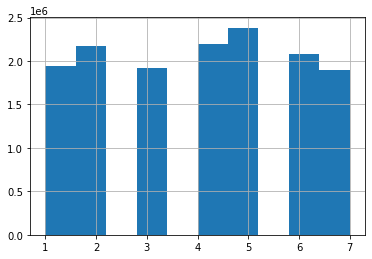

In [66]:
# Plot how many recommendations were made in each week
augmented_reco_df["date"].dt.isocalendar().day.hist()

<AxesSubplot:ylabel='Frequency'>

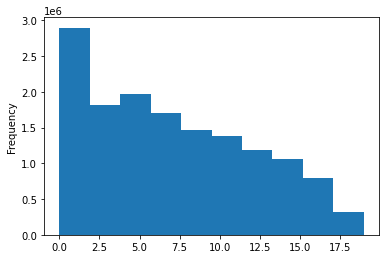

In [67]:
# How many recommendations made in each week since signup
augmented_reco_df["days_since_signup"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

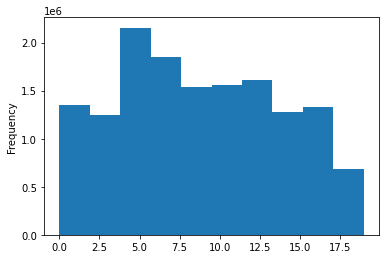

In [68]:
# Frequency of every week index in the dataset
augmented_reco_df["day_index"].plot.hist()

In [69]:
augmented_reco_df.head()

,timestamp,user,item,datetime,signup_date,date,day_index,days_since_signup
0,1.684742e+12,2399631,6471660,2023-05-22 07:51:21.120,2023-05-22,2023-05-22,0,0
1,1.684742e+12,2399631,2374719,2023-05-22 07:51:21.120,2023-05-22,2023-05-22,0,0
2,1.684742e+12,2399631,6479989,2023-05-22 07:51:21.120,2023-05-22,2023-05-22,0,0
3,1.684742e+12,2399631,2908630,2023-05-22 07:51:21.120,2023-05-22,2023-05-22,0,0
4,1.684742e+12,2399631,3274279,2023-05-22 07:51:21.120,2023-05-22,2023-05-22,0,0


In [70]:
# Write intermediate data to folder for reuse
augmented_reco_df.to_csv(f"{result_folder}/augmented_reco_df.csv", index=False)

In [71]:
augmented_reco_df = pd.merge(augmented_reco_df, item_metadata_df, on="item")

In [72]:
augmented_reco_df

,timestamp,user,item,datetime,signup_date,date,day_index,days_since_signup,tag
0,1.684742e+12,2399631,6471660,2023-05-22 07:51:21.120000000,2023-05-22,2023-05-22,0,0,0
1,1.684912e+12,2411280,6471660,2023-05-24 07:11:58.547000064,2023-05-23,2023-05-24,2,1,0
2,1.684742e+12,2399631,2374719,2023-05-22 07:51:21.120000000,2023-05-22,2023-05-22,0,0,9
3,1.685415e+12,2400449,2374719,2023-05-30 02:44:28.944999936,2023-05-22,2023-05-30,8,8,9
4,1.685248e+12,2400202,2374719,2023-05-28 04:30:50.969999872,2023-05-26,2023-05-28,6,2,9
...,...,...,...,...,...,...,...,...,...
14605707,1.686323e+12,2417719,3930325,2023-06-09 15:09:05.531000064,2023-05-23,2023-06-09,18,17,25
14605708,1.686360e+12,2423480,4559065,2023-06-10 01:23:26.668999936,2023-05-30,2023-06-10,19,11,20
14605709,1.686360e+12,2410969,5785504,2023-06-10 01:16:30.432999936,2023-05-25,2023-06-10,19,16,18
14605710,1.686360e+12,2423480,4185730,2023-06-10 01:26:29.296999936,2023-05-30,2023-06-10,19,11,20


# Group Into Observations

In [73]:
recommendations_grouped_day = augmented_reco_df.groupby(["user", "day_index", "days_since_signup"]).agg({"item": lambda x: len(set(x)), "tag": lambda y: len(set(y))}).reset_index().rename(columns={"item": "count", "tag": "variety"})

In [74]:
recommendations_grouped_day

,user,day_index,days_since_signup,count,variety
0,291,3,0,47,12
1,1059,0,0,70,18
2,1059,1,1,7,5
3,1059,13,13,1,1
4,5350,1,0,1,1
...,...,...,...,...,...
149405,2425088,6,0,6,3
149406,2425088,8,2,6,2
149407,2425089,5,0,11,9
149408,2425090,5,0,12,9


In [75]:
recommendations_grouped_day.to_csv(
    f"{base_folder}/samples_for_model.csv",
    index=False,
    header=True,
)